#01 Data Collection and Preprocessing:

Collect a labeled dataset containing images of products with various defects. Ensure that each image is labeled with the corresponding defect class.
Preprocess the images, which may include resizing, normalization, and augmentation to enhance the diversity of the dataset.

In [ ]:
# Step 1: Import Libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1.0 Data Folder
train_dir = '/content/drive/MyDrive/screw/train/good'
test_dir = '/content/drive/MyDrive/screw/test'
ground_truth_dir = '/content/drive/MyDrive/screw/ground_truth'

In [ ]:
train_dir

'/content/drive/MyDrive/screw/train/good'

## Check data distribution

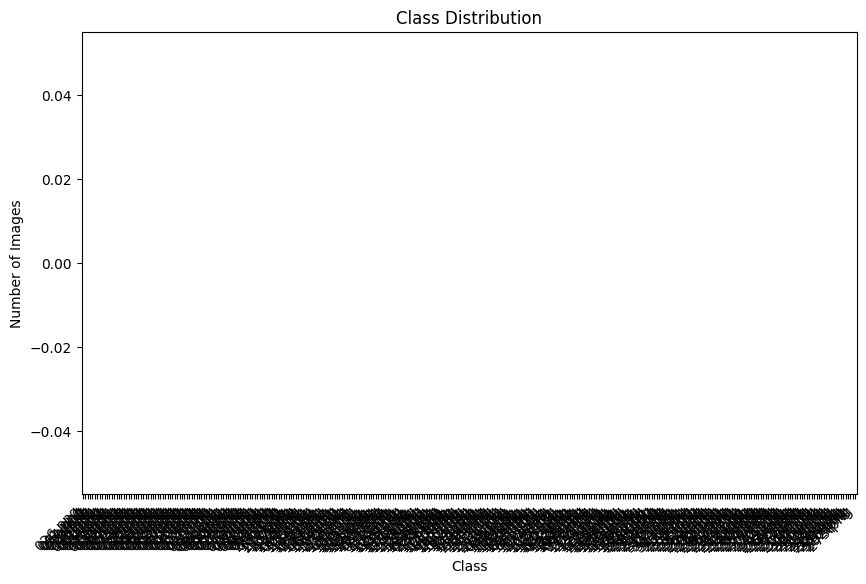

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names, excluding system files like .DS_Store
class_names = [class_name for class_name in os.listdir(train_dir) if not class_name.startswith('.DS_Store')]

# Count the number of images in each class
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) if os.path.isdir(os.path.join(train_dir, class_name)) else 0 for class_name in class_names]

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


Class distribution for the Test folder:


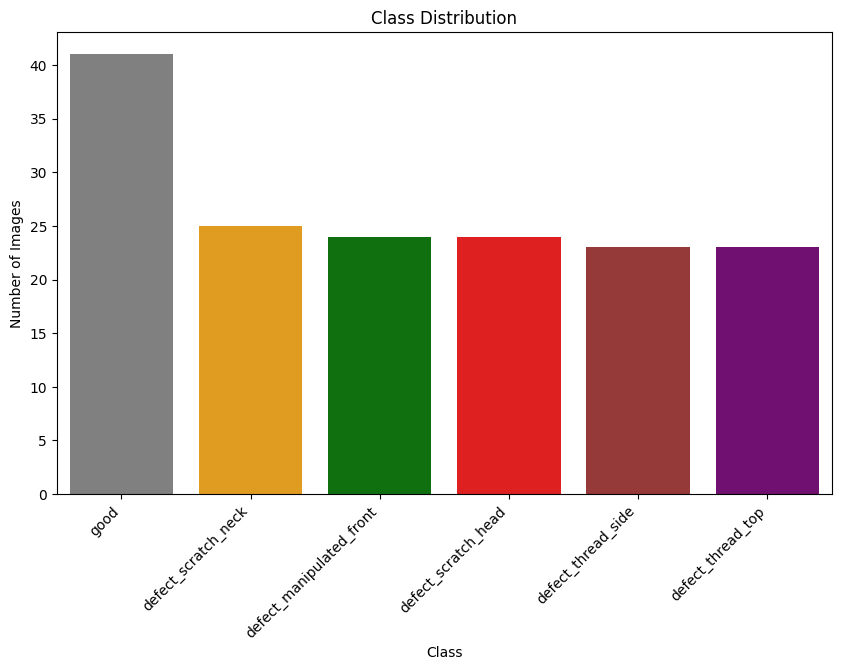

Class distribution for the Ground Truth folder:


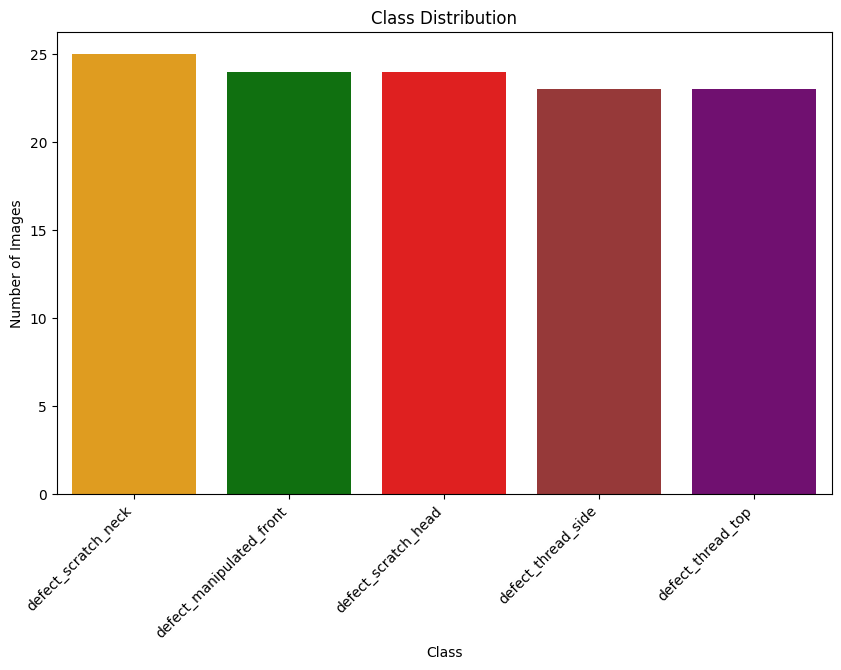

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(folder_path):
    # Get class names, excluding system files like .DS_Store
    class_names = [class_name for class_name in os.listdir(folder_path) if not class_name.startswith('.DS_Store')]

    # Count the number of images in each class
    class_counts = [len(os.listdir(os.path.join(folder_path, class_name))) for class_name in class_names]


    # Create a color map for each class
    class_colors = {
        'defect_scratch_neck': 'orange',
        'defect_manipualted_front': 'green',
        'defect_scratch_head': 'red',
        'defect_thread_top': 'purple',
        'defect_thread_side': 'brown',
        'good': 'gray'
    }

    # Sort class names based on counts in descending order
    sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k], reverse=True)
    class_names = [class_names[i] for i in sorted_indices]
    class_counts = [class_counts[i] for i in sorted_indices]


    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_counts, palette=[class_colors.get(class_name, 'green') for class_name in class_names])

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45, ha='right')

    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()


# Plot class distribution for the Test folder
print("Class distribution for the Test folder:")
plot_class_distribution(test_dir)

# Plot class distribution for the Ground Truth folder
print("Class distribution for the Ground Truth folder:")
plot_class_distribution(ground_truth_dir)


In [ ]:
# Step 2.0 Data Preposessing
def load_data(directory, label, convert_to_grayscale=True, normalize=True):
    data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):  # assuming images are in PNG format
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # if using OpenCV, convert BGR to RGB
            img = cv2.resize(img, (224, 224))  # adjust size according to your network input size
            data.append(img)
            labels.append(label)


    # Add print statements
    print(f"Folder: {directory}, Label: {label}, Number of images: {len(data)}")

    # Assuming images is a list of images or an array
    for idx, image in enumerate(data):
    # Add print statements about each image (if needed)
        print(f"Image {idx + 1}: Shape - {image.shape}")


    return np.array(data), np.array(labels)

In [ ]:
# Load Good images from Train directory in grayscale and normalize
good_data, good_labels = load_data(train_dir, label=0, convert_to_grayscale=True, normalize=True)


Folder: /content/drive/MyDrive/screw/train/good, Label: 0, Number of images: 320
Image 1: Shape - (224, 224, 3)
Image 2: Shape - (224, 224, 3)
Image 3: Shape - (224, 224, 3)
Image 4: Shape - (224, 224, 3)
Image 5: Shape - (224, 224, 3)
Image 6: Shape - (224, 224, 3)
Image 7: Shape - (224, 224, 3)
Image 8: Shape - (224, 224, 3)
Image 9: Shape - (224, 224, 3)
Image 10: Shape - (224, 224, 3)
Image 11: Shape - (224, 224, 3)
Image 12: Shape - (224, 224, 3)
Image 13: Shape - (224, 224, 3)
Image 14: Shape - (224, 224, 3)
Image 15: Shape - (224, 224, 3)
Image 16: Shape - (224, 224, 3)
Image 17: Shape - (224, 224, 3)
Image 18: Shape - (224, 224, 3)
Image 19: Shape - (224, 224, 3)
Image 20: Shape - (224, 224, 3)
Image 21: Shape - (224, 224, 3)
Image 22: Shape - (224, 224, 3)
Image 23: Shape - (224, 224, 3)
Image 24: Shape - (224, 224, 3)
Image 25: Shape - (224, 224, 3)
Image 26: Shape - (224, 224, 3)
Image 27: Shape - (224, 224, 3)
Image 28: Shape - (224, 224, 3)
Image 29: Shape - (224, 224, 3)


In [ ]:
%%capture
good_labels

In [ ]:

# Load Defect Image
defect_data, defect_labels = [], []

# Get a list of folders in the main directory
defect_folders = os.listdir(test_dir)

# Mapping of folder names to labels
defect_labels_mapping = {
    'defect_scratch_neck': 1,
    'defect_manipulated_front': 2,
    'defect_scratch_head': 3,
    'defect_thread_top': 4,
    'defect_thread_side': 5,
}

# Iterate through each folder
for folder in defect_folders:
    if folder.startswith("defect"):
        defect_folder_path = os.path.join(test_dir, folder)

        # Get the label for the current class
        label = defect_labels_mapping.get(folder, -1)

        # Load data only if label is valid
        if label != -1:
            # Call your load_data function here
            defect_images, _ = load_data(defect_folder_path, label=label, convert_to_grayscale=True, normalize=True)

            # Check if defect_images is empty
            if len(defect_images) == 0:
                print("No images found in the defect folder.")
            else:
                # Print the number of images for the defect folder
                print(f"Number of images for {folder}: {len(defect_images)}")

                # Debug each image within the defect folder
                for idx, image in enumerate(defect_images):
                    print(f"Image {idx + 1}: Shape - {image.shape}")

                # Extend the defect data and labels
                defect_data.extend(defect_images)
                defect_labels.extend([label] * len(defect_images))


Folder: /content/drive/MyDrive/screw/test/defect_scratch_neck, Label: 1, Number of images: 25
Image 1: Shape - (224, 224, 3)
Image 2: Shape - (224, 224, 3)
Image 3: Shape - (224, 224, 3)
Image 4: Shape - (224, 224, 3)
Image 5: Shape - (224, 224, 3)
Image 6: Shape - (224, 224, 3)
Image 7: Shape - (224, 224, 3)
Image 8: Shape - (224, 224, 3)
Image 9: Shape - (224, 224, 3)
Image 10: Shape - (224, 224, 3)
Image 11: Shape - (224, 224, 3)
Image 12: Shape - (224, 224, 3)
Image 13: Shape - (224, 224, 3)
Image 14: Shape - (224, 224, 3)
Image 15: Shape - (224, 224, 3)
Image 16: Shape - (224, 224, 3)
Image 17: Shape - (224, 224, 3)
Image 18: Shape - (224, 224, 3)
Image 19: Shape - (224, 224, 3)
Image 20: Shape - (224, 224, 3)
Image 21: Shape - (224, 224, 3)
Image 22: Shape - (224, 224, 3)
Image 23: Shape - (224, 224, 3)
Image 24: Shape - (224, 224, 3)
Image 25: Shape - (224, 224, 3)
Number of images for defect_scratch_neck: 25
Image 1: Shape - (224, 224, 3)
Image 2: Shape - (224, 224, 3)
Image 3:

#02 Data Splitting:

Divide your dataset into training, validation, and testing sets. This helps assess the model's performance on new, unseen data.

In [ ]:
# Step 3: Load and Split Data
import numpy as np

# Make sure all images have the same dimensions
all_good_data = [np.squeeze(img) for img in good_data]
# Extract only 60% of the good images
percentage_to_use = 0.6
num_images_to_use = int(len(good_data) * percentage_to_use)

# Update the code to use only 40% of the good images
good_data = [np.squeeze(img)[:int(img.shape[0]*percentage_to_use), :int(img.shape[1]*percentage_to_use)] for img in all_good_data[:num_images_to_use]]
good_data = [np.squeeze(img) for img in good_data]
defect_data = [np.squeeze(img) for img in defect_data]

##Size Op 1

In [ ]:
import cv2

# Resize all images to a common size
common_size = (224, 224)  # Specify the desired size
good_data_resized = [cv2.resize(img, common_size) for img in good_data]
defect_data_resized = [cv2.resize(img, common_size) for img in defect_data]

# Combine resized data and labels
X = np.concatenate([good_data_resized, defect_data_resized], axis=0)
# Assuming that the label for "good" is 0
y_good = np.zeros(len(good_data), dtype=int)
y_defect = np.array(defect_labels)

# Combine labels for "good" and "defect"
y = np.concatenate([y_good, y_defect], axis=0)

## Size Op 2 299,299


In [ ]:
# import cv2

# # Resize all images to a common size
# inception_size = (299, 299)  # Specify the desired size
# good_data_resized = [cv2.resize(img, inception_size) for img in good_data]
# defect_data_resized = [cv2.resize(img, inception_size) for img in defect_data]

# # Combine resized data and labels
# X = np.concatenate([good_data_resized, defect_data_resized], axis=0)
# # Assuming that the label for "good" is 0
# y_good = np.zeros(len(good_data), dtype=int)
# y_defect = np.array(defect_labels)

# # Combine labels for "good" and "defect"
# y = np.concatenate([y_good, y_defect], axis=0)

## 03 run the size Then run the split

In [ ]:
# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# from tensorflow.keras.utils import to_categorical

# y_train_encoded = to_categorical(y_train, num_classes=6)
# y_val_encoded = to_categorical(y_val, num_classes=6)
# y_test_encoded = to_categorical(y_test, num_classes=6)


Model Selection:

Choose a suitable deep learning model architecture for your multiclass classification task. Convolutional Neural Networks (CNNs) are commonly used for computer vision tasks.

Model Design:

Design the architecture of your model.
The input layer should match the size of your preprocessed images, and the output layer should have as many nodes as the number of classes (defect types).
Loss Function:

Select a suitable loss function for multiclass classification.
Cross-entropy loss is commonly used in this context. >> use one-hot encoded
loss='sparse_categorical_crossentropy' >> use integer

Optimizer:

Choose an optimizer (e.g., Adam, SGD) to update the model's weights during training.

In [ ]:
"""from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model on top of the pre-trained ResNet50
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes (6 in your case)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 32
epochs = 5

history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
"""

'from tensorflow.keras.applications import ResNet50\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n\n# Define image dimensions\nimg_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images\n\n# Create an ImageDataGenerator with augmentation parameters\ndatagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    vertical_flip=True,\n    fill_mode=\'nearest\'\n)\n\n# Load pre-trained ResNet50 model\nbase_model = ResNet50(weights=\'imagenet\', include_top=False, input_shape=(img_height, img_width, img_channels))\n\n# Freeze the base model layers\nfor layer in base_model.layers:\n    layer.trainable = False\n\n# Build the model on top of the pre-trained R

In [ ]:
#test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)


Training:

Train the model using the training set. Adjust the hyperparameters such as learning rate, batch size, and the number of epochs to achieve good performance. Monitor the training process using the validation set to avoid overfitting.

## **Review Model Architecture:**

In [ ]:
#model.summary()

In [ ]:
"""# Train the model
batch_size = 32
num_train_batches = len(X_train) // batch_size
model.fit(X_train, y_train_encoded, epochs=5, batch_size=batch_size, validation_split=0.2) ##without validation data"""

'# Train the model\nbatch_size = 32\nnum_train_batches = len(X_train) // batch_size\nmodel.fit(X_train, y_train_encoded, epochs=5, batch_size=batch_size, validation_split=0.2) ##without validation data'

Evaluation:

Evaluate the model's performance on the testing set. Common metrics for multiclass classification include accuracy, precision, recall, and F1 score.

# validationdata

In [ ]:
"""# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_acc}')"""

"# Step 7: Evaluate Model\ntest_loss, test_acc = model.evaluate(X_test, y_test_encoded)\nprint(f'Test Accuracy: {test_acc}')"

In [ ]:
"""# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')"""

"# Validate with new, unseen data\nnew_loss, new_accuracy = model.evaluate(X_val, y_val_encoded)\nprint(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')"

In [ ]:
#predictions = model.predict(X_test)

In [ ]:
"""# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")"""

'# Convert predictions to class indices (assuming softmax activation in the output layer)\npredicted_classes = np.argmax(predictions, axis=1)\n\n# Assuming \'y_test\' contains the true class labels\ntrue_classes = y_test\n\n# Calculate metrics for each class\nprecision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)\nrecall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)\nf1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)\n\n# Calculate overall metrics using \'weighted\nprecision_weighted = precision_score(true_classes, predicted_classes, average=\'weighted\', zero_division=1)\nrecall_weighted = recall_score(true_classes, predicted_classes, average=\'weighted\', zero_division=1)\nf1_weighted = f1_score(true_classes, predicted_classes, average=\'weighted\', zero_division=1)\naccuracy = accuracy_score(true_classes, predicted_classes)\n\n# Print the metrics for each cl

Fine-tuning:

Based on the evaluation results, fine-tune the model by adjusting hyperparameters or modifying the architecture to improve performance.

# Model1


In [ ]:

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten

In [ ]:


# Function to create a Keras model
def create_model(units=16, activation_function='relu', optimizer='adam', learning_rate=0.01, epochs=5):
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))  # Flatten layer for image input
    model.add(Dense(units, activation=activation_function))
    model.add(Dense(6, activation='softmax'))  # Assuming 6 classes
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Define hyperparameters to tune
param_grid = {
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50]
}


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
##      loss='categorical_crossentropy'
##train_loss	train_accuracy	val_loss	val_accuracy
##1.480451	0.745247	1.412330	0.750000
# {'model': <keras.src.engine.sequential.Sequential at 0x2dfe37ed0>,
#  'parameters': {'activation_function': 'sigmoid',
#   'epochs': 20,
#   'learning_rate': 0.1,
#   'optimizer': 'rmsprop',
#   'units': 32},
#  'metrics': {'train_loss': 1.4804505109786987,
#   'train_accuracy': 0.7452471256256104,
#   'val_loss': 1.4123297929763794,
#   'val_accuracy': 0.75}}


In [ ]:
models = dict()
all_params = ParameterGrid(param_grid)
for idx, params in enumerate(all_params):
    model = create_model(**params)
    model.fit(X_train, y_train)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            train_loss=train_loss,
            train_accuracy=train_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy,
        )
    )
    print(f"Processed {idx}")

3/3 [==============================] - 0s 26ms/step - loss: 3569.9634 - accuracy: 0.7500
Processed 0
3/3 [==============================] - 0s 36ms/step - loss: 13766.7598 - accuracy: 0.7500
Processed 1
3/3 [==============================] - 0s 37ms/step - loss: 12868.1494 - accuracy: 0.7500
Processed 2
3/3 [==============================] - 0s 12ms/step - loss: 1.7833 - accuracy: 0.7500
Processed 3
3/3 [==============================] - 0s 16ms/step - loss: 10252.7031 - accuracy: 0.7500
Processed 4
3/3 [==============================] - 0s 25ms/step - loss: 39882.5039 - accuracy: 0.7500
Processed 5
3/3 [==============================] - 0s 13ms/step - loss: 1.7837 - accuracy: 0.7500
Processed 6
3/3 [==============================] - 0s 20ms/step - loss: 2728.9995 - accuracy: 0.0568
Processed 7
3/3 [==============================] - 0s 37ms/step - loss: 19455.7832 - accuracy: 0.7500
Processed 8
3/3 [==============================] - 0s 12ms/step - loss: 1.7858 - accuracy: 0.7500
Proces

In [ ]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 38ms/step - loss: 0.9986 - accuracy: 0.7452


[0.9985887408256531, 0.7452471256256104]

In [ ]:
import pandas as pd
df = pd.DataFrame([model.get("metrics") for model in models.values()])

In [ ]:
df.sort_values("val_accuracy")

,train_loss,train_accuracy,val_loss,val_accuracy
73,1.547604,0.068441,1.589330,0.022727
105,1.788437,0.068441,1.885511,0.022727
54,2.753717,0.068441,2.796535,0.022727
67,1.696043,0.068441,1.756939,0.022727
76,1.547879,0.068441,1.598483,0.022727
...,...,...,...,...
32,19616.300781,0.745247,16498.712891,0.750000
31,1.788960,0.745247,1.788957,0.750000
27,1.789239,0.745247,1.789000,0.750000
107,0.998589,0.745247,1.012201,0.750000


In [ ]:
models.get(16)

{'model': <keras.src.engine.sequential.Sequential at 0x77ff4283b8b0>,
 'parameters': {'activation_function': 'relu',
  'epochs': 10,
  'learning_rate': 0.2,
  'optimizer': 'rmsprop',
  'units': 32},
 'metrics': {'train_loss': 1.786082148551941,
  'train_accuracy': 0.7414448857307434,
  'val_loss': 1.7876415252685547,
  'val_accuracy': 0.7613636255264282}}

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)


9/9 [==============================] - 0s 36ms/step - loss: 0.9986 - accuracy: 0.7452


In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

3/3 [==============================] - 0s 67ms/step - loss: 1.2932 - accuracy: 0.6591
Test Accuracy: 0.6590909361839294


In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

3/3 [==============================] - 0s 55ms/step - loss: 1.0122 - accuracy: 0.7500
New Data Loss: 1.012200951576233, New Data Accuracy: 0.75


In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 0s 20ms/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 0s 25ms/step
The predicted class is: Good


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model2

In [ ]:

# Function to create a Keras model
def model2_convolutional_layers(units=16, activation_function='relu', optimizer='adam', learning_rate=0.01, epochs=5):
    model = Sequential()

    # Add 3 convolutional layers with increasing filter sizes
    model.add(Conv2D(32, (3, 3), activation=activation_function, input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (7, 7), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the extracted features
    model.add(Flatten())

    model.add(Dense(units, activation=activation_function))
    model.add(Dense(6, activation='softmax'))  # Assuming 6 classes
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# # Define hyperparameters to tune
param_grid = {
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50]
}


model2_convolutional_layers takes a lot of time and the accuracy did not go beyond 75%. After 40% process, decided to stop.

In [ ]:

models = dict()
all_params = ParameterGrid(param_grid)
for idx, params in enumerate(all_params):
    model = model2_convolutional_layers(**params)
    model.fit(X_train, y_train)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            train_loss=train_loss,
            train_accuracy=train_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy,
        )
    )
    print(f"Processed {idx}")

NameError: ignored

In [ ]:

# Function to create a Keras model
def model2_convolutional_layers(units=16, activation_function='relu', optimizer='adam', learning_rate=0.01, epochs=5):
    model = Sequential()

    # Add 3 convolutional layers with increasing filter sizes
    model.add(Conv2D(32, (3, 3), activation=activation_function, input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (7, 7), activation=activation_function))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the extracted features
    model.add(Flatten())

    model.add(Dense(units, activation=activation_function))
    model.add(Dense(6, activation='softmax'))  # Assuming 6 classes
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# # Define hyperparameters to tune
param_grid = {
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50]
}


# Model3

In [ ]:
def model3_dense_layer(units=16, activation_function='relu', optimizer='adam', learning_rate=0.01, epochs=10):
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))  # Flatten layer for image input
    model.add(Dense(units, activation=activation_function))

    # Added two additional dense layers
    model.add(Dense(32, activation=activation_function))
    model.add(Dense(64, activation=activation_function))

    model.add(Dense(6, activation='softmax'))  # Assuming 6 classes
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
# # Define hyperparameters to tune
param_grid = {
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50]
}

In [ ]:

models = dict()
all_params = ParameterGrid(param_grid)
for idx, params in enumerate(all_params):
    model = model3_dense_layer(**params)
    model.fit(X_train, y_train)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            train_loss=train_loss,
            train_accuracy=train_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy,
        )
    )
    print(f"Processed {idx}")

3/3 [==============================] - 0s 13ms/step - loss: 1112.1841 - accuracy: 0.0682
Processed 0
3/3 [==============================] - 0s 14ms/step - loss: 1463.4082 - accuracy: 0.7500
Processed 1
3/3 [==============================] - 0s 24ms/step - loss: 719.9486 - accuracy: 0.7500
Processed 2
3/3 [==============================] - 0s 14ms/step - loss: 2212.9221 - accuracy: 0.7500
Processed 3
3/3 [==============================] - 0s 20ms/step - loss: 2863.6567 - accuracy: 0.6477
Processed 4
3/3 [==============================] - 0s 24ms/step - loss: 11961.0371 - accuracy: 0.0455
Processed 5
3/3 [==============================] - 0s 15ms/step - loss: 1753.8104 - accuracy: 0.7500
Processed 6
3/3 [==============================] - 0s 14ms/step - loss: 2576.5044 - accuracy: 0.7500
Processed 7
3/3 [==============================] - 0s 36ms/step - loss: 1578.5730 - accuracy: 0.7500
Processed 8
3/3 [==============================] - 0s 32ms/step - loss: 176.1731 - accuracy: 0.7500
Pro

In [ ]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 1s 54ms/step - loss: 1.2693 - accuracy: 0.7452


[1.2692726850509644, 0.7452471256256104]

In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

3/3 [==============================] - 0s 56ms/step - loss: 1.3397 - accuracy: 0.6591
Test Accuracy: 0.6590909361839294


In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

3/3 [==============================] - 0s 50ms/step - loss: 1.2756 - accuracy: 0.7500
New Data Loss: 1.2756043672561646, New Data Accuracy: 0.75


In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 1s 56ms/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import pandas as pd
df = pd.DataFrame([model.get("metrics") for model in models.values()])

In [ ]:
df.sort_values("val_accuracy")

,train_loss,train_accuracy,val_loss,val_accuracy
53,18516.662109,0.068441,19725.689453,0.022727
83,1.508902,0.068441,1.553679,0.022727
72,1.852033,0.068441,1.865706,0.022727
67,1.925251,0.068441,1.975399,0.022727
47,5062.930176,0.068441,5817.880859,0.022727
...,...,...,...,...
42,1.777699,0.745247,1.777081,0.750000
40,6790.384277,0.745247,7753.991699,0.750000
39,140.412170,0.745247,116.517265,0.750000
37,3688.012939,0.745247,3132.199219,0.750000


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['train_accuracy'].plot(kind='hist', bins=20, title='train_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['val_loss'].plot(kind='hist', bins=20, title='val_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='train_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='train_loss', y='train_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='train_accuracy', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='val_loss', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_accuracy']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('val_accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_accuracy')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_accuracy']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('val_accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_accuracy')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_accuracy']
  ys = series['train_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('val_accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_accuracy')
_ = plt.ylabel('train_accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_accuracy']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('val_accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_accuracy')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['train_accuracy'].plot(kind='line', figsize=(8, 4), title='train_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['val_loss'].plot(kind='line', figsize=(8, 4), title='val_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

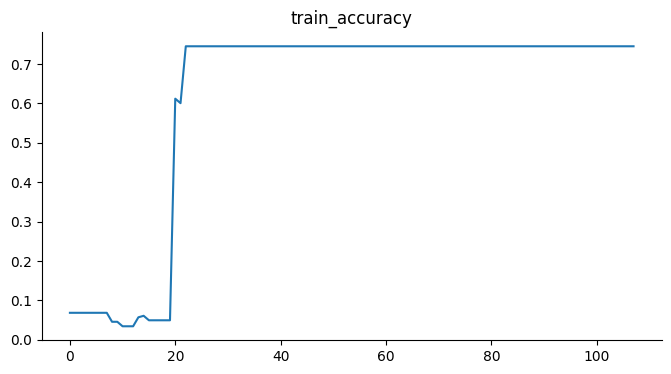

In [ ]:
from matplotlib import pyplot as plt
_df_14['train_accuracy'].plot(kind='line', figsize=(8, 4), title='train_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

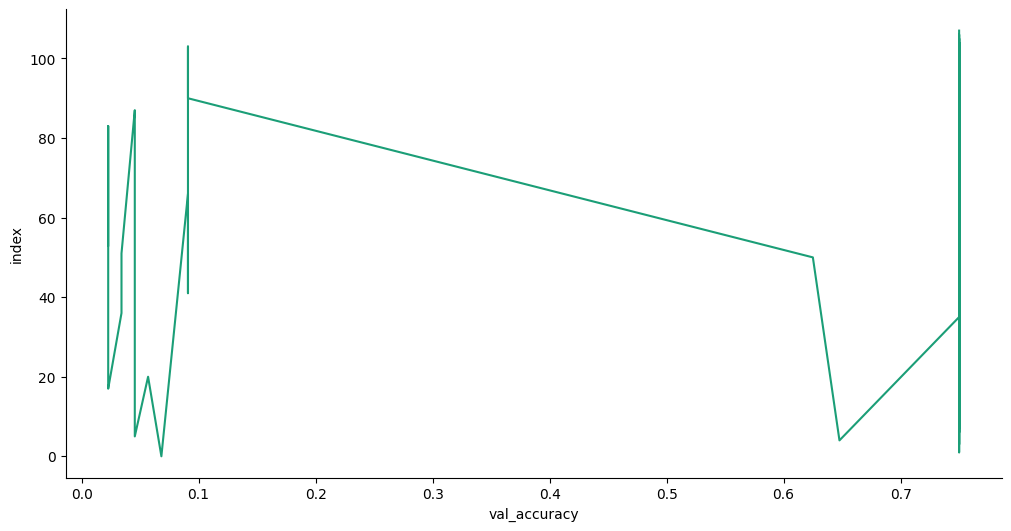

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_accuracy']
  ys = series['index']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('val_accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_accuracy')
_ = plt.ylabel('index')

# Model4 ResNet as base model


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model on top of the pre-trained ResNet50
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 32
epochs = 20

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
5/8 [=================>............] - ETA: 17s - loss: 250.9380 - accuracy: 0.4222

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

In [ ]:
predictions = model.predict(X_test)

In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
import pandas as pd
df = pd.DataFrame([model.get("metrics") for model in models.values()])

In [ ]:
df.sort_values("val_accuracy")

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assume X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and test data

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50],
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
}

models = dict()
all_params = ParameterGrid(param_grid)

# Loop through hyperparameter combinations
for idx, params in enumerate(all_params):
    # Create a new ResNet50-based model with data augmentation
    img_height, img_width, img_channels = 224, 224, 3
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

    # Compile the model with hyperparameters
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fit the model with data augmentation
    batch_size = 32
    epochs = params['epochs']

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Save the model and its metrics
    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            test_loss=test_loss,
            test_accuracy=test_accuracy,
        )
    )

    print(f"Processed {idx}")


# Model5 ResNet Only


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 5

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/5
16/16 [==============================] - 77s 5s/step - loss: 39.0373 - accuracy: 0.5506 - val_loss: 33.0900 - val_accuracy: 0.5682
Epoch 2/5
16/16 [==============================] - 115s 7s/step - loss: 19.5273 - accuracy: 0.6154 - val_loss: 12.1438 - val_accuracy: 0.4886
Epoch 3/5
16/16 [==============================] - 84s 5s/step - loss: 10.4209 - accuracy: 0.6802 - val_loss: 15.4094 - val_accuracy: 0.1818
Epoch 4/5
16/16 [==============================] - 70s 4s/step - loss: 10.6178 - accuracy: 0.6397 - val_loss: 11.7761 - val_accuracy: 0.7159
Epoch 5/5
16/16 [==============================] - 75s 5s/step - loss: 10.3045 - accuracy: 0.6761 - val_loss: 9.2072 - val_accuracy: 0.5795
Test Loss: 13.1775
Test Accuracy: 0.5227


In [ ]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 53s 6s/step - loss: 8.4500 - accuracy: 0.6046


[8.449980735778809, 0.6045627593994141]

In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

3/3 [==============================] - 18s 6s/step - loss: 9.2072 - accuracy: 0.5795
New Data Loss: 9.207208633422852, New Data Accuracy: 0.5795454382896423


In [ ]:
# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50],
    'units': [16, 32, 64],
    'activation_function': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [8,16,32]
}

models = dict()
all_params = ParameterGrid(param_grid)

# Loop through hyperparameter combinations
for idx, params in enumerate(all_params):
    # Create a new ResNet50-based model with data augmentation
    img_height, img_width, img_channels = 224, 224, 3
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

    # Compile the model with hyperparameters
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fit the model with data augmentation
    batch_size = params['batch_size']
    epochs = params['epochs']

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Save the model and its metrics
    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            test_loss=test_loss,
            test_accuracy=test_accuracy,
        )
    )

    print(f"Processed {idx}")


Epoch 1/10
32/32 [==============================] - 76s 2s/step - loss: 4.4650 - accuracy: 0.6157 - val_loss: 2.8788 - val_accuracy: 0.5682
Epoch 2/10
32/32 [==============================] - 72s 2s/step - loss: 3.0427 - accuracy: 0.7020 - val_loss: 1.8464 - val_accuracy: 0.6023
Epoch 3/10
32/32 [==============================] - 93s 3s/step - loss: 1.8104 - accuracy: 0.6941 - val_loss: 1.7808 - val_accuracy: 0.7500
Epoch 4/10
32/32 [==============================] - 72s 2s/step - loss: 1.5449 - accuracy: 0.7255 - val_loss: 4.1394 - val_accuracy: 0.2273
Epoch 5/10
32/32 [==============================] - 71s 2s/step - loss: 1.9738 - accuracy: 0.6510 - val_loss: 2.7717 - val_accuracy: 0.3977
Epoch 6/10
32/32 [==============================] - 73s 2s/step - loss: 2.3511 - accuracy: 0.6941 - val_loss: 2.5933 - val_accuracy: 0.4773
Epoch 7/10
32/32 [==============================] - 72s 2s/step - loss: 2.0011 - accuracy: 0.6863 - val_loss: 1.7877 - val_accuracy: 0.4659
Epoch 8/10
32/32 [==

In [ ]:


models = dict()
all_params = ParameterGrid(param_grid)
for idx, params in enumerate(all_params):
    model = model3_dense_layer(**params)
    model.fit(X_train, y_train)
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            train_loss=train_loss,
            train_accuracy=train_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy,
        )
    )
    print(f"Processed {idx}")

NameError: ignored

# Model6


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:

# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 10
learning_rate = 0.01
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
5/5 [==============================] - 27s 5s/step - loss: 47.9063 - accuracy: 0.2466 - val_loss: 50.3246 - val_accuracy: 0.4333
Epoch 2/10
5/5 [==============================] - 23s 5s/step - loss: 26.0464 - accuracy: 0.4500 - val_loss: 35.1546 - val_accuracy: 0.4667
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 34.2359 - accuracy: 0.3973 - val_loss: 32.9270 - val_accuracy: 0.4000
Epoch 4/10
5/5 [==============================] - 26s 6s/step - loss: 16.6055 - accuracy: 0.3562 - val_loss: 12.3345 - val_accuracy: 0.4667
Epoch 5/10
5/5 [==============================] - 26s 5s/step - loss: 14.2742 - accuracy: 0.4795 - val_loss: 10.9409 - val_accuracy: 0.5667
Epoch 6/10
5/5 [==============================] - 21s 5s/step - loss: 19.6151 - accuracy: 0.5068 - val_loss: 17.9648 - val_accuracy: 0.4667
Epoch 7/10
5/5 [==============================] - 23s 4s/step - loss: 16.5910 - accuracy: 0.4795 - val_loss: 11.6161 - val_accuracy: 0.6000
Epoch 8/10
5/5 [====

In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

1/1 [==============================] - 8s 8s/step - loss: 12.9837 - accuracy: 0.5333
Test Accuracy: 0.5333333611488342


In [ ]:
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.5333333611488342


In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

1/1 [==============================] - 5s 5s/step - loss: 22.4750 - accuracy: 0.4667
New Data Loss: 22.474992752075195, New Data Accuracy: 0.46666666865348816


In [ ]:
predictions = model.predict(X_test)

1/1 [==============================] - 7s 7s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 2 Metrics:
  Precision: 0.5000
  Recall: 0.1667
  F1 Score: 0.2500
Class 3 Metrics:
  Precision: 0.4737
  Recall: 1.0000
  F1 Score: 0.6429
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.6088
Weighted Recall: 0.5333
Weighted F1 Score: 0.4429
Accuracy: 0.5333


In [ ]:
true_classes

array([2, 1, 1, 5, 0, 3, 0, 2, 1, 1, 3, 5, 0, 2, 2, 2, 2, 2, 4, 2, 0, 3,
       1, 1, 3, 0, 2, 5, 5, 0])

In [ ]:
predicted_classes

array([2, 2, 2, 2, 0, 1, 0, 2, 5, 2, 2, 2, 0, 2, 2, 2, 2, 2, 5, 2, 0, 5,
       1, 2, 2, 0, 2, 2, 2, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 0s 371ms/step
The predicted class is: Good


In [ ]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


Confusion Matrix:
True Positives: 1
True Negatives: 6
False Positives: 0
False Negatives: 0

Overall Metrics:
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Weighted F1 Score: 1.0000
Accuracy: 1.0000

Result:
Test Loss: 12.9837
Test Accuracy: 0.5333
Val Loss: 0.9800
Val Accuracy: 0.7500


# Model 7

*   Hyperparameter tuning and params
*   List item



In [ ]:


# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 10
learning_rate = 0.01
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
16/16 [==============================] - 66s 4s/step - loss: 27.8660 - accuracy: 0.5789 - val_loss: 26.9121 - val_accuracy: 0.3750
Epoch 2/10
16/16 [==============================] - 66s 4s/step - loss: 26.6093 - accuracy: 0.6478 - val_loss: 20.5345 - val_accuracy: 0.6364
Epoch 3/10
16/16 [==============================] - 66s 4s/step - loss: 15.4182 - accuracy: 0.6194 - val_loss: 19.3905 - val_accuracy: 0.6250
Epoch 4/10
16/16 [==============================] - 65s 4s/step - loss: 18.1401 - accuracy: 0.6721 - val_loss: 12.8198 - val_accuracy: 0.6818
Epoch 5/10
16/16 [==============================] - 66s 4s/step - loss: 16.2157 - accuracy: 0.6397 - val_loss: 20.0769 - val_accuracy: 0.2614
Epoch 6/10
16/16 [==============================] - 66s 4s/step - loss: 12.4683 - accuracy: 0.6721 - val_loss: 14.6107 - val_accuracy: 0.7500
Epoch 7/10
16/16 [==============================] - 72s 5s/step - loss: 10.0783 - accuracy: 0.6599 - val_loss: 6.7644 - val_accuracy: 0.6818
Epoch 8

In [ ]:
# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'epochs': [10, 20, 50],
}

models = dict()
all_params = ParameterGrid(param_grid)

# Loop through hyperparameter combinations
for idx, params in enumerate(all_params):
    # Create a new ResNet50-based model with data augmentation
    img_height, img_width, img_channels = 224, 224, 3
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

    for layer in base_model.layers:
        layer.trainable = False

    # model = Sequential()
    # model.add(base_model)
    # model.add(GlobalAveragePooling2D())
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes


    # Build the model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fit the model with data augmentation
    batch_size = 16
    unit = 32

    # Compile the model with hyperparameters
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fit the model with data augmentation
    batch_size = 32
    epochs = params['epochs']

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Save the model and its metrics
    models[idx] = dict(
        model=model,
        parameters=params,
        metrics=dict(
            test_loss=test_loss,
            test_accuracy=test_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy,
        )
    )

    print(f"Processed {idx}")


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
8/8 [==============================] - 42s 5s/step - loss: 4.7619 - accuracy: 0.5801 - val_loss: 7.9675 - val_accuracy: 0.0227
Epoch 2/10
8/8 [==============================] - 39s 5s/step - loss: 3.9108 - accuracy: 0.5671 - val_loss: 2.0579 - val_accuracy: 0.7727
Epoch 3/10
8/8 [==============================] - 39s 5s/step - loss: 2.8249 - accuracy: 0.6494 - val_loss: 1.7475 - val_accuracy: 0.5682
Epoch 4/10
8/8 [==============================] - 38s 5s/step - loss: 1.8570 - accuracy: 0.7359 - val_loss: 2.2549 - val_accuracy: 0.4205
Epoch 5/10
8/8 [==============================] - 38s 5s/step - loss: 1.5500 - accuracy: 0.6797 - val_loss: 1.0812 - val_accuracy: 0.7500
Epoch 6/10
8/8 [==============================] - 38s 5s/step - loss: 1.2371 - accuracy: 0.6840 - val_loss: 1.0145 - val_accuracy: 0.7045
Epoch 7/10
8/8 [==============================] - 46s 6s/step - loss: 0.8885 - accuracy: 0.7489 - val_loss:

IndentationError: ignored

In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

3/3 [==============================] - 11s 4s/step - loss: 25.8053 - accuracy: 0.5909
Test Accuracy: 0.5909090638160706


In [ ]:
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.5909090638160706


In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

3/3 [==============================] - 11s 3s/step - loss: 20.6703 - accuracy: 0.7159
New Data Loss: 20.67030906677246, New Data Accuracy: 0.7159090638160706


In [ ]:
import pandas as pd
df = pd.DataFrame([model.get("metrics") for model in models.values()])
df

,test_loss,test_accuracy
0,1.293576,0.625000
1,14.566669,0.534091
2,22.457415,0.625000
3,1.109914,0.568182
4,8.713120,0.477273
5,16.385410,0.363636
6,1.139143,0.704545
7,9.557130,0.625000
8,25.805254,0.590909


from matplotlib import pyplot as plt
df['test_loss'].plot(kind='hist', bins=20, title='test_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['test_accuracy'].plot(kind='hist', bins=20, title='test_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='test_loss', y='test_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['test_loss'].plot(kind='line', figsize=(8, 4), title='test_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['test_accuracy'].plot(kind='line', figsize=(8, 4), title='test_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

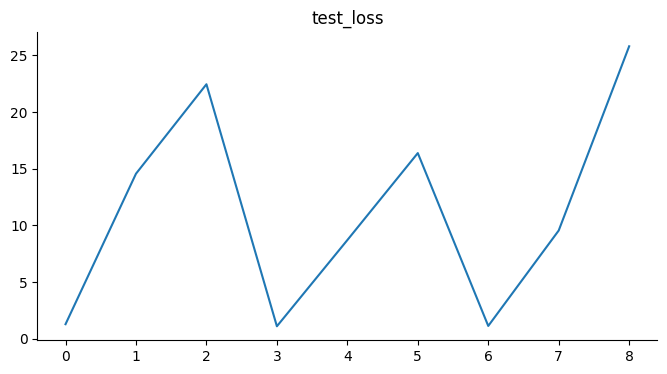

In [ ]:
from matplotlib import pyplot as plt
df['test_loss'].plot(kind='line', figsize=(8, 4), title='test_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 12s 4s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.8065
  Recall: 0.8621
  F1 Score: 0.8333
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 0.6667
  Recall: 0.2222
  F1 Score: 0.3333
Class 5 Metrics:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7020
Weighted Recall: 0.5909
Weighted F1 Score: 0.5833
Accuracy: 0.5909


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([3, 0, 3, 3, 3, 4, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 3, 0, 3, 0, 3,
       3, 0, 3, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 4, 3, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 2s 2s/step
The predicted class is: Good


# Model8

In [ ]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 20
learning_rate = 0.1
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)



print(f"Processed {idx}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20
16/16 [==============================] - 56s 3s/step - loss: 138.3250 - accuracy: 0.4899 - val_loss: 4.6878 - val_accuracy: 0.7500
Epoch 2/20
16/16 [==============================] - 52s 3s/step - loss: 4.3415 - accuracy: 0.6964 - val_loss: 1.0612 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 51s 3s/step - loss: 1.8709 - accuracy: 0.7449 - val_loss: 0.9702 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 51s 3s/step - loss: 0.9325 - accuracy: 0.7611 - val_loss: 0.9808 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 42s 3s/step - loss: 0.9708 - accuracy: 0.7449 - val_loss: 0.9776 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 51s 3s/step - loss: 0.9543 - accuracy: 0.7530 - val_loss: 0.9758 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 51s 3s/step - loss: 0.9742 - accuracy: 0.7449 - val_loss: 0.9801 - val_accuracy: 0.7500
Epoch 8/20
16/16 [

In [ ]:
# Step 7: Evaluate Model
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=3)

# Save the model and its metrics
models[idx] = dict(
    model=model,
    parameters=params,
    metrics=dict(
        test_loss=test_loss,
        test_accuracy=test_accuracy,
        val_loss=val_loss,
        val_accuracy=val_accuracy,
    )
)

In [ ]:
import pandas as pd
df = pd.DataFrame([model.get("metrics") for model in models.values()])
df.sort_values("val_accuracy")

,test_loss,test_accuracy,val_loss,val_accuracy
8,1.231787,0.659091,0.985403,0.75
0,1.293576,0.625000,NaN,NaN
1,14.566669,0.534091,NaN,NaN
2,22.457415,0.625000,NaN,NaN
3,1.109914,0.568182,NaN,NaN
4,8.713120,0.477273,NaN,NaN
5,16.385410,0.363636,NaN,NaN
6,1.139143,0.704545,NaN,NaN
7,9.557130,0.625000,NaN,NaN


from matplotlib import pyplot as plt
_df_0['test_loss'].plot(kind='hist', bins=20, title='test_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['test_accuracy'].plot(kind='hist', bins=20, title='test_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['val_loss'].plot(kind='hist', bins=20, title='val_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['val_accuracy'].plot(kind='hist', bins=20, title='val_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='test_loss', y='test_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='test_accuracy', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='val_loss', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['test_loss'].plot(kind='line', figsize=(8, 4), title='test_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['test_accuracy'].plot(kind='line', figsize=(8, 4), title='test_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['val_loss'].plot(kind='line', figsize=(8, 4), title='val_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['val_accuracy'].plot(kind='line', figsize=(8, 4), title='val_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")

Test Loss: 1.2318
Test Accuracy: 0.6591
Val Loss: 0.9854
Val Accuracy: 0.7500


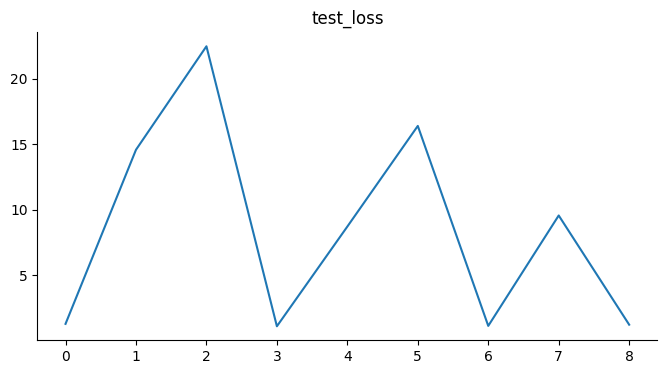

In [ ]:
from matplotlib import pyplot as plt
df['test_loss'].plot(kind='line', figsize=(8, 4), title='test_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 11s 3s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 1s 830ms/step
The predicted class is: Good


# Model9


*   Adjusted weight loss
*   



In [ ]:
# Import necessary libraries
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
# Define the weighting function
def weighted_loss(y_true, y_pred):
    # Calculate the number of samples belonging to each class using TensorFlow operations
    class_counts = tf.reduce_sum(y_true, axis=0)

    # Calculate class weights using TensorFlow operations
    class_weights = class_counts / tf.reduce_sum(class_counts)

    # Apply weights to the loss using TensorFlow operations
    weighted_losses = CategoricalCrossentropy(from_logits=True)(y_true, y_pred) * class_weights

    # Sum the weighted losses to get the final loss
    loss = tf.reduce_sum(weighted_losses)

    return loss

from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=6)
y_val_one_hot = to_categorical(y_val, num_classes=6)


In [ ]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='CategoricalCrossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 20
learning_rate = 0.1
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

print(f"Processed {idx}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20
16/16 [==============================] - 54s 3s/step - loss: 120.5723 - accuracy: 0.5304 - val_loss: 17.9115 - val_accuracy: 0.7500
Epoch 2/20
16/16 [==============================] - 43s 3s/step - loss: 5.9531 - accuracy: 0.5992 - val_loss: 1.0426 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 52s 3s/step - loss: 1.0658 - accuracy: 0.7490 - val_loss: 0.9651 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 52s 3s/step - loss: 0.9824 - accuracy: 0.7449 - val_loss: 0.9618 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 51s 3s/step - loss: 0.9967 - accuracy: 0.7368 - val_loss: 1.0103 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 42s 3s/step - loss: 1.1813 - accuracy: 0.7490 - val_loss: 0.9772 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 51s 3s/step - loss: 1.3285 - accuracy: 0.7368 - val_loss: 0.9835 - val_accuracy: 0.7500
Epoch 8/20
16/16 

In [ ]:
# Step 7: Evaluate Model
# Evaluate the model on the test set






Val Loss: 0.9854
Val Accuracy: 0.7500


In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")

Test Loss: 1.2318
Test Accuracy: 0.6591
Val Loss: 0.9854
Val Accuracy: 0.7500


In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 14s 4s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 1s 822ms/step
The predicted class is: Good


# Model 10

*   loss
*   Unfreeze the last few layers of ResNet50



In [ ]:


# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Example: Unfreeze the last few layers of ResNet50
for layer in base_model.layers[:-10]:
    layer.trainable = True


# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 20
learning_rate = 0.01
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20
16/16 [==============================] - 128s 8s/step - loss: 18.8148 - accuracy: 0.6883 - val_loss: 133732612105809564686272088244224.0000 - val_accuracy: 0.7500
Epoch 2/20
16/16 [==============================] - 123s 8s/step - loss: 2.4055 - accuracy: 0.7328 - val_loss: 1863515075674571276288.0000 - val_accuracy: 0.7500
Epoch 3/20
16/16 [==============================] - 122s 8s/step - loss: 1.1398 - accuracy: 0.7368 - val_loss: 1745988897210368.0000 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 129s 8s/step - loss: 1.0661 - accuracy: 0.7287 - val_loss: 1001765666816.0000 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 122s 8s/step - loss: 1.1606 - accuracy: 0.7287 - val_loss: 6358988800.0000 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 123s 8s/step - loss: 1.1021 - accuracy: 0.7409 - val_loss: 89889784.0000 - val_accuracy: 0.7500
Epoch 7/20
16/16 [==============================] - 123s 

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 244.1944
Test Accuracy: 0.6591


In [ ]:
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.5909090638160706


In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

3/3 [==============================] - 10s 3s/step - loss: 154.6988 - accuracy: 0.7500
New Data Loss: 154.69883728027344, New Data Accuracy: 0.75


In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 13s 3s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 1s 807ms/step
The predicted class is: Good


# Model11


In [ ]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 50
learning_rate = 0.1
unit = 32
activation_function = 'sigmoid'

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)



94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
16/16 [==============================] - 84s 5s/step - loss: 127.0624 - accuracy: 0.4818 - val_loss: 9.4821 - val_accuracy: 0.7500
Epoch 2/50
16/16 [==============================] - 73s 5s/step - loss: 2.5369 - accuracy: 0.6842 - val_loss: 1.0011 - val_accuracy: 0.7500
Epoch 3/50
16/16 [==============================] - 73s 5s/step - loss: 1.1209 - accuracy: 0.7449 - val_loss: 0.9714 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 73s 5s/step - loss: 2.1820 - accuracy: 0.7409 - val_loss: 0.9808 - val_accuracy: 0.7500
Epoch 5/50
16/16 [==============================] - 74s 5s/step - loss: 1.0442 - accuracy: 0.7490 - val_loss: 0.9826 - val_accuracy: 0.7500
Epoch 6/50
16/16 [==============================] - 76s 5s/step - loss: 0.9912 - accuracy: 0.7383 - val_loss: 0.9761 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 72s 5s/step - loss: 0.9891 - accuracy: 0.

In [ ]:
# Step 7: Evaluate Model
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)



In [ ]:
# Save the model and its metrics
models[idx] = dict(
    model=model,
    metrics=dict(
        test_loss=test_loss,
        test_accuracy=test_accuracy,
        val_loss=val_loss,
        val_accuracy=val_accuracy,
    )
)

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")

Test Loss: 1.2339
Test Accuracy: 0.6591
Val Loss: 0.9800
Val Accuracy: 0.7500


In [ ]:
predictions = model.predict(X_test)

3/3 [==============================] - 34s 10s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 0.6591
  Recall: 1.0000
  F1 Score: 0.7945
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.7753
Weighted Recall: 0.6591
Weighted F1 Score: 0.5237
Accuracy: 0.6591


In [ ]:
true_classes

array([0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 2, 1, 0, 0, 4, 1, 4, 3, 0, 4, 0, 3,
       1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 3, 5, 0, 0, 0, 1])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/010.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 1s 830ms/step
The predicted class is: Good


# Model12

*   InceptionV3
*   List item




In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Load pre-trained InceptionV3 model
img_height, img_width, img_channels = 299, 299, 3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with on-the-fly data augmentation
batch_size = 16
epochs = 10

# Create a generator for training data with on-the-fly data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

# Calculate steps_per_epoch based on the number of augmented samples
steps_per_epoch = len(X_train) // batch_size

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)


Test Loss: 860.5224
Test Accuracy: 0.1786


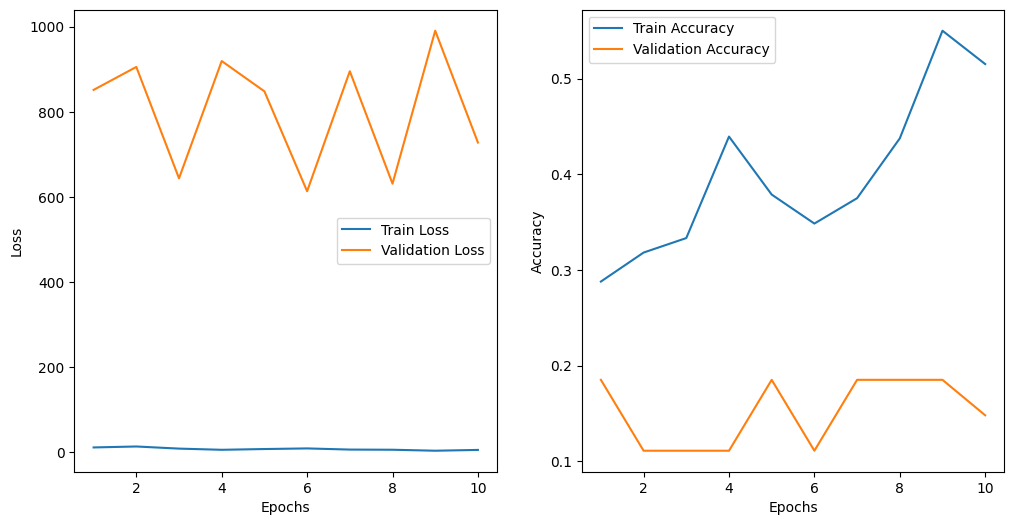

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Record the training history
train_loss_history = history.history['loss']
train_accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# Plotting the time series graph
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [ ]:
# Evaluate additional metrics on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate weighted precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1_score:.4f}")

# Evaluate metrics on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate metrics on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/1 [==============================] - 11s 11s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Precision: 0.0431
Weighted Recall: 0.1786
Weighted F1 Score: 0.0694
Training Loss: 664.3351
Training Accuracy: 0.1463
Validation Loss: 727.7688
Validation Accuracy: 0.1481


In [ ]:
# Step 7: Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

1/1 [==============================] - 6s 6s/step - loss: 860.5224 - accuracy: 0.1786
Test Accuracy: 0.1785714328289032


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

TypeError: ignored

In [ ]:
true_classes

array([2, 1, 1, 5, 0, 3, 0, 2, 1, 1, 3, 5, 0, 2, 2, 2, 2, 2, 4, 2, 0, 3,
       1, 1, 3, 0, 2, 5, 5, 0])

In [ ]:
predicted_classes

array([2, 2, 2, 2, 0, 1, 0, 2, 5, 2, 2, 2, 0, 2, 2, 2, 2, 2, 5, 2, 0, 5,
       1, 2, 2, 0, 2, 2, 2, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 0s 371ms/step
The predicted class is: Good


In [ ]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


Confusion Matrix:
True Positives: 1
True Negatives: 6
False Positives: 0
False Negatives: 0

Overall Metrics:
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Weighted F1 Score: 1.0000
Accuracy: 1.0000

Result:
Test Loss: 12.9837
Test Accuracy: 0.5333
Val Loss: 0.9800
Val Accuracy: 0.7500


# Model13


*   Efficient50
*   List item




In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 10

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
11/11 [==============================] - 31s 2s/step - loss: 7.5398 - accuracy: 0.5765 - val_loss: 6.0934 - val_accuracy: 0.4194
Epoch 2/10
11/11 [==============================] - 26s 2s/step - loss: 4.8061 - accuracy: 0.6529 - val_loss: 2.9605 - val_accuracy: 0.7419
Epoch 3/10
11/11 [==============================] - 20s 2s/step - loss: 3.8607 - accuracy: 0.7059 - val_loss: 3.7885 - val_accuracy: 0.6935
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 3.2723 - accuracy: 0.6882 - val_loss: 3.7731 - val_accuracy: 0.8226
Epoch 5/10
11/11 [==============================] - 24s 2s/step - loss: 3.9382 - accuracy: 0.6818 - val_loss: 3.6804 - val_accuracy: 0.6935
Epoch 6/10
11/11 [==============================] - 20s 2s/step - loss: 3.3661 - accuracy: 0.8118 - val_loss: 1.6040 - val_accuracy: 0.7419
Epoch 7/10
11/11 [==============================] - 21s 2s/step - loss: 2.0566 - accuracy: 0.80

Test Loss: 2.4460
Test Accuracy: 0.7778


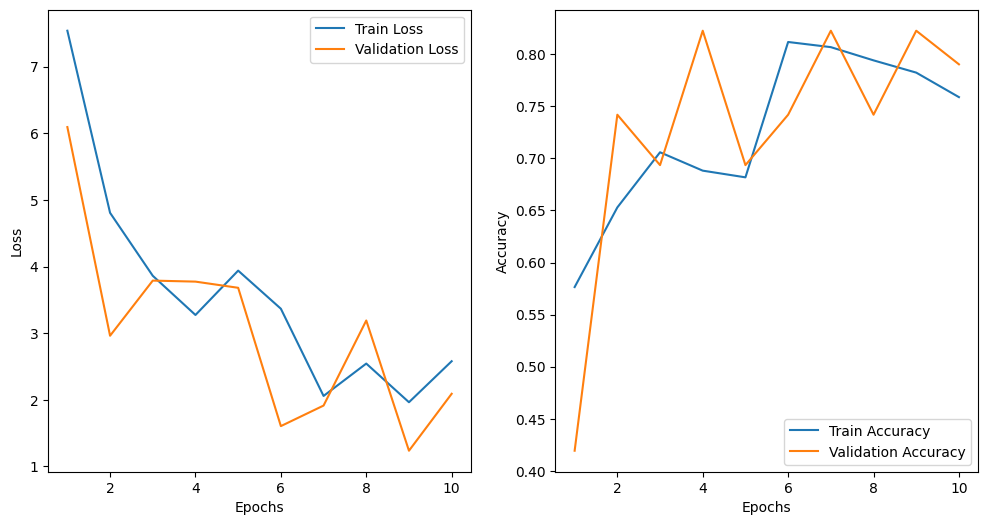

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Record the training history
train_loss_history = history.history['loss']
train_accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# Plotting the time series graph
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [ ]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

1/1 [==============================] - 5s 5s/step - loss: 22.4750 - accuracy: 0.4667
New Data Loss: 22.474992752075195, New Data Accuracy: 0.46666666865348816


In [ ]:
predictions = model.predict(X_test)

1/1 [==============================] - 7s 7s/step


In [ ]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 2 Metrics:
  Precision: 0.5000
  Recall: 0.1667
  F1 Score: 0.2500
Class 3 Metrics:
  Precision: 0.4737
  Recall: 1.0000
  F1 Score: 0.6429
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 0.6088
Weighted Recall: 0.5333
Weighted F1 Score: 0.4429
Accuracy: 0.5333


In [ ]:
true_classes

array([2, 1, 1, 5, 0, 3, 0, 2, 1, 1, 3, 5, 0, 2, 2, 2, 2, 2, 4, 2, 0, 3,
       1, 1, 3, 0, 2, 5, 5, 0])

In [ ]:
predicted_classes

array([2, 2, 2, 2, 0, 1, 0, 2, 5, 2, 2, 2, 0, 2, 2, 2, 2, 2, 5, 2, 0, 5,
       1, 2, 2, 0, 2, 2, 2, 0])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 0s 371ms/step
The predicted class is: Good


In [ ]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


Confusion Matrix:
True Positives: 1
True Negatives: 6
False Positives: 0
False Negatives: 0

Overall Metrics:
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Weighted F1 Score: 1.0000
Accuracy: 1.0000

Result:
Test Loss: 12.9837
Test Accuracy: 0.5333
Val Loss: 0.9800
Val Accuracy: 0.7500


# Model14


*   Efficient50
*   List item




In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import numpy as np
from tensorflow.keras.optimizers import Adam, RMSprop


In [ ]:


# Function to create and compile the model with given hyperparameters
def create_model(units, activation_function, optimizer, learning_rate, epochs, batch_size):
    # Load EfficientNetB0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units, activation=activation_function))
    model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

    # Compile the model
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Define hyperparameters to tune
param_grid = {
    'units': [32],
    'activation_function': ['sigmoid'],
    'optimizer': [Adam, RMSprop],  # Use the actual optimizer classes
    'learning_rate': [0.01, 0.1],
    'epochs': [20, 50],
    'batch_size': [16,32]
}

# Use ParameterGrid to iterate through all hyperparameter combinations
all_params = list(ParameterGrid(param_grid))

models = []

for idx, params in enumerate(all_params):
    # Create and compile the model
    model = create_model(**params)

    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=params['batch_size']),
        steps_per_epoch=len(X_train) // params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)

    models.append({
        'model': model,
        'parameters': params,
        'history': history.history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f"Processed {idx}")



16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20
11/11 [==============================] - 30s 2s/step - loss: 1.2724 - accuracy: 0.5529 - val_loss: 0.9217 - val_accuracy: 0.6935
Epoch 2/20
11/11 [==============================] - 23s 2s/step - loss: 0.9136 - accuracy: 0.6471 - val_loss: 0.7125 - val_accuracy: 0.7258
Epoch 3/20
11/11 [==============================] - 19s 2s/step - loss: 0.7798 - accuracy: 0.6706 - val_loss: 0.8059 - val_accuracy: 0.7581
Epoch 4/20
11/11 [==============================] - 22s 2s/step - loss: 0.6914 - accuracy: 0.7294 - val_loss: 0.5816 - val_accuracy: 0.7742
Epoch 5/20
11/11 [==============================] - 19s 2s/step - loss: 0.6932 - accuracy: 0.6882 - val_loss: 0.6022 - val_accuracy: 0.7581
Epoch 6/20
11/11 [==============================] - 23s 2s/step - loss: 0.6162 - accuracy: 0.7294 - val_loss: 0.5509 - val_accuracy: 0.7581
Epoch 7/20
11/11 [==============================] - 20s 2s/step - loss: 0.6586 - accuracy: 0.72

Test Loss: 1.5282
Test Accuracy: 0.6825


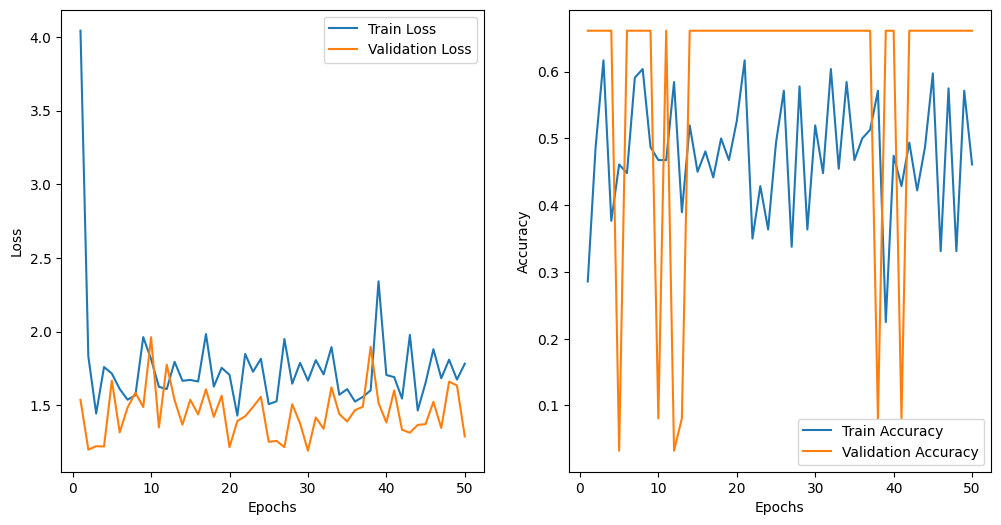

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Record the training history
train_loss_history = history.history['loss']
train_accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

epochs=params['epochs']

# Plotting the time series graph
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [79]:
predictions = model.predict(X_test)

2/2 [==============================] - 5s 3s/step


In [78]:
import pandas as pd

# Assuming train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history are lists

# Create a DataFrame
history_df = pd.DataFrame({
    'Epoch': epochs_range,
    'Train Loss': train_loss_history,
    'Train Accuracy': train_accuracy_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_accuracy_history
})

# Display the DataFrame
print(history_df)


    Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
0       1    4.042120        0.285714         1.536680             0.661290
1       2    1.831833        0.487013         1.199050             0.661290
2       3    1.443994        0.616883         1.222036             0.661290
3       4    1.759744        0.376623         1.220537             0.661290
4       5    1.715389        0.461039         1.666996             0.032258
5       6    1.610522        0.448052         1.316383             0.661290
6       7    1.537854        0.590909         1.483968             0.661290
7       8    1.567973        0.603896         1.585191             0.661290
8       9    1.962777        0.487013         1.488158             0.661290
9      10    1.812686        0.467532         1.962131             0.080645
10     11    1.625351        0.467532         1.349632             0.661290
11     12    1.610305        0.584416         1.775248             0.032258
12     13   

In [81]:
import pandas as pd
from tabulate import tabulate
# Assuming train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history are lists

# Create a DataFrame
history_df = pd.DataFrame({
    'Epoch': epochs_range,
    'Train Loss': train_loss_history,
    'Train Accuracy': train_accuracy_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_accuracy_history
})

# Display the DataFrame

table = tabulate(history_df, headers='keys', tablefmt='pretty', showindex=False)

print(table)

+-------+--------------------+---------------------+--------------------+----------------------+
| Epoch |     Train Loss     |   Train Accuracy    |  Validation Loss   | Validation Accuracy  |
+-------+--------------------+---------------------+--------------------+----------------------+
|  1.0  | 4.042119979858398  | 0.2857142984867096  | 1.536679983139038  |  0.6612903475761414  |
|  2.0  | 1.8318328857421875 | 0.48701298236846924 | 1.1990504264831543 |  0.6612903475761414  |
|  3.0  | 1.4439936876296997 | 0.6168830990791321  | 1.2220364809036255 |  0.6612903475761414  |
|  4.0  | 1.7597438097000122 | 0.37662336230278015 | 1.220536708831787  |  0.6612903475761414  |
|  5.0  | 1.7153888940811157 | 0.4610389471054077  | 1.6669957637786865 | 0.032258063554763794 |
|  6.0  | 1.6105215549468994 | 0.44805195927619934 | 1.3163833618164062 |  0.6612903475761414  |
|  7.0  | 1.5378538370132446 | 0.5909090638160706  | 1.483967900276184  |  0.6612903475761414  |
|  8.0  | 1.5679725408554077 |

In [80]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 0.0000
  Recall: 1.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 1.0000
Weighted Recall: 0.0000
Weighted F1 Score: 0.0000
Accuracy: 0.0000


In [ ]:
true_classes

In [ ]:
predicted_classes

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


In [ ]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


# Model14.1


*   Efficient50
*   Best Val Acc
```
32,sigmoid,Adam,0.1,50,16,0.3234,0.8706,0.4959,0.8387
```


In [82]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [85]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 32, activation='sigmoid'))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 16
epochs = 50

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
11/11 [==============================] - 31s 2s/step - loss: 1.9811 - accuracy: 0.5235 - val_loss: 1.2927 - val_accuracy: 0.4839
Epoch 2/50
11/11 [==============================] - 24s 2s/step - loss: 1.1266 - accuracy: 0.6118 - val_loss: 0.9687 - val_accuracy: 0.7097
Epoch 3/50
11/11 [==============================] - 20s 2s/step - loss: 1.0381 - accuracy: 0.6235 - val_loss: 0.8035 - val_accuracy: 0.6935
Epoch 4/50
11/11 [==============================] - 20s 2s/step - loss: 0.9605 - accuracy: 0.6588 - val_loss: 0.6573 - val_accuracy: 0.7258
Epoch 5/50
11/11 [==============================] - 20s 2s/step - loss: 0.8970 - accuracy: 0.6471 - val_loss: 0.8382 - val_accuracy: 0.7419
Epoch 6/50
11/11 [==============================] - 21s 2s/step - loss: 0.7954 - accuracy: 0.6471 - val_loss: 0.5853 - val_accuracy: 0.7097
Epoch 7/50
11/11 [==============================] - 24s 2s/step - loss: 0.8136 - accuracy: 0.6471 - val_loss: 0.8258 - val_accuracy: 0.6452
Epoch 8/50
11/11 [==

2/2 [==============================] - 6s 3s/step - loss: 0.8754 - accuracy: 0.6935
Test Loss: 1.2751
Test Accuracy: 0.6190


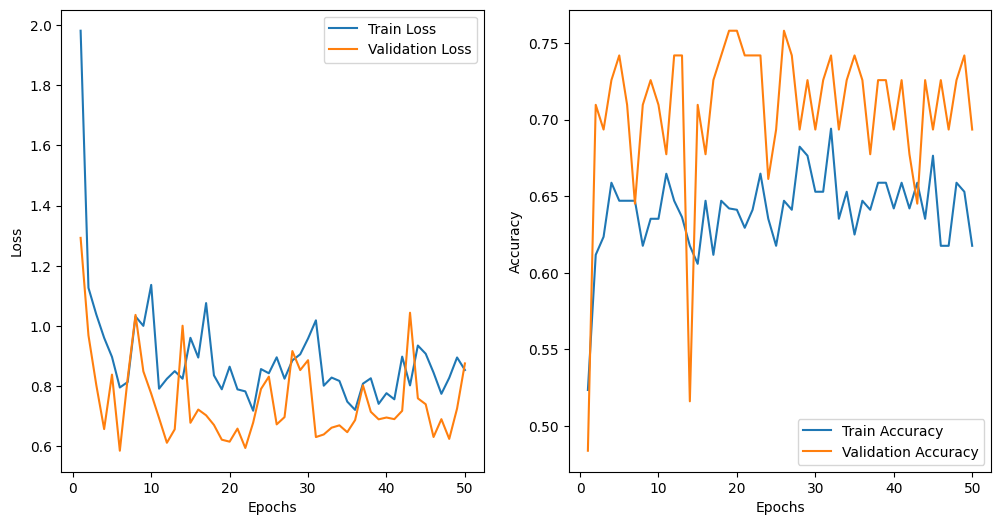

In [86]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Record the training history
train_loss_history = history.history['loss']
train_accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# Plotting the time series graph
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [87]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

2/2 [==============================] - 4s 2s/step - loss: 0.8754 - accuracy: 0.6935
New Data Loss: 0.875417947769165, New Data Accuracy: 0.6935483813285828


In [88]:
predictions = model.predict(X_test)

2/2 [==============================] - 9s 3s/step


In [89]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 1.0000
  Recall: 0.9070
  F1 Score: 0.9512
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 0.0000
  Recall: 1.0000
  F1 Score: 0.0000
Class 6 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Metrics:
Weighted Precision: 1.0000
Weighted Recall: 0.6190
Weighted F1 Score: 0.6492
Accuracy: 0.6190


In [90]:
true_classes

array([0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       3, 0, 0, 0, 3, 0, 1, 0, 5, 0, 5, 3, 0, 0, 0, 1, 2, 0, 3, 2, 0, 5,
       0, 0, 0, 3, 1, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])

In [91]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       4, 0, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4,
       0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4])

In [92]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 2s 2s/step
The predicted class is: Good


In [93]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


Confusion Matrix:
True Positives: 0
True Negatives: 39
False Positives: 0
False Negatives: 0

Overall Metrics:
Weighted Precision: 0.0000
Weighted Recall: 0.0000
Weighted F1 Score: 0.0000
Accuracy: 1.0000

Result:
Test Loss: 1.2751
Test Accuracy: 0.6190
Val Loss: 0.8754
Val Accuracy: 0.6935


In [94]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Your true and predicted classes
true_classes = true_classes



# Calculate confusion matrix using sklearn
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Extract TP, TN, FP, FN values from the confusion matrix
TP = conf_matrix[1, 1]  # True Positive
TN = conf_matrix[0, 0]  # True Negative
FP = conf_matrix[0, 1]  # False Positive
FN = conf_matrix[1, 0]  # False Negative

print(f'True Positive (TP): {TP}')
print(f'True Negative (TN): {TN}')
print(f'False Positive (FP): {FP}')
print(f'False Negative (FN): {FN}')

print("Confusion Matrix:")
print(conf_matrix)

True Positive (TP): 0
True Negative (TN): 39
False Positive (FP): 0
False Negative (FN): 0
Confusion Matrix:
[[39  0  0  0  4  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  5  0]]


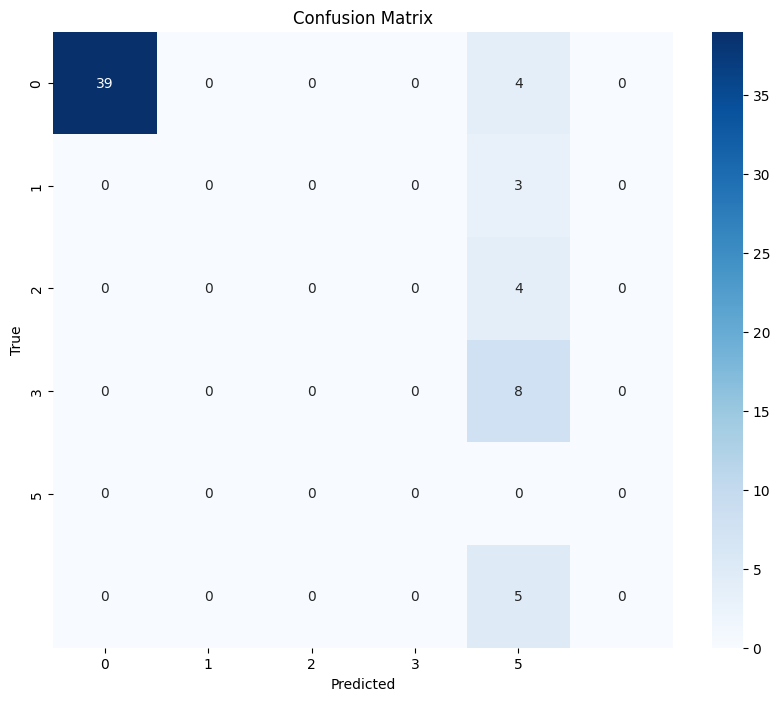

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



# Model14.2


*   Efficient50
*   Best Val Acc


```
32,sigmoid,RMSprop,0.1,50,32,0.4253,0.8377,0.3854,0.871
```


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [96]:
# Define image dimensions
img_height, img_width, img_channels = 224, 224, 3  # Adjust based on your images

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 32, activation='sigmoid'))
model.add(Dense(6, activation='softmax'))  # Adjust to the number of classes

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
batch_size = 32
epochs = 50

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
5/5 [==============================] - 31s 5s/step - loss: 3.2376 - accuracy: 0.3377 - val_loss: 1.7640 - val_accuracy: 0.6613
Epoch 2/50
5/5 [==============================] - 24s 5s/step - loss: 1.5214 - accuracy: 0.5875 - val_loss: 1.2135 - val_accuracy: 0.6613
Epoch 3/50
5/5 [==============================] - 20s 4s/step - loss: 1.3825 - accuracy: 0.5312 - val_loss: 1.2067 - val_accuracy: 0.5161
Epoch 4/50
5/5 [==============================] - 22s 5s/step - loss: 1.2386 - accuracy: 0.5649 - val_loss: 0.9663 - val_accuracy: 0.6935
Epoch 5/50
5/5 [==============================] - 26s 5s/step - loss: 1.0420 - accuracy: 0.5844 - val_loss: 1.0693 - val_accuracy: 0.5161
Epoch 6/50
5/5 [==============================] - 20s 4s/step - loss: 0.9287 - accuracy: 0.6039 - val_loss: 1.0788 - val_accuracy: 0.6452
Epoch 7/50
5/5 [==============================] - 19s 4s/step - loss: 0.9056 - accuracy: 0.6558 - val_loss: 0.6809 - val_accuracy: 0.7419
Epoch 8/50
5/5 [==================

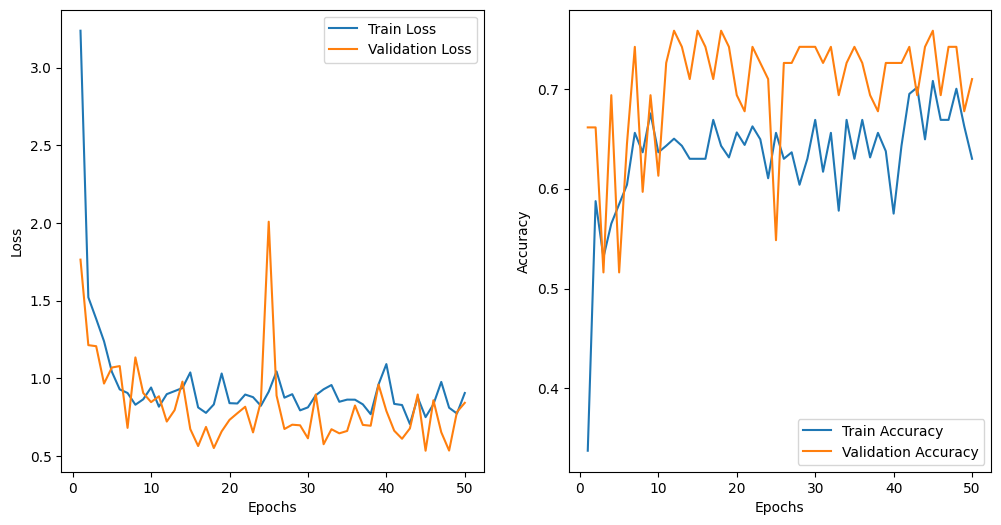

In [97]:


# Record the training history
train_loss_history = history.history['loss']
train_accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# Plotting the time series graph
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [98]:
# Validate with new, unseen data
new_loss, new_accuracy = model.evaluate(X_val, y_val)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')

2/2 [==============================] - 4s 2s/step - loss: 0.8422 - accuracy: 0.7097
New Data Loss: 0.842245876789093, New Data Accuracy: 0.7096773982048035


In [99]:
predictions = model.predict(X_test)

2/2 [==============================] - 8s 2s/step


In [100]:
# Convert predictions to class indices (assuming softmax activation in the output layer)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming 'y_test' contains the true class labels
true_classes = y_test

# Calculate metrics for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None, zero_division=1)
recall_per_class = recall_score(true_classes, predicted_classes, average=None, zero_division=1)
f1_per_class = f1_score(true_classes, predicted_classes, average=None, zero_division=1)

# Calculate overall metrics using 'weighted
precision_weighted = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall_weighted = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1_weighted = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics for each class
for class_idx in range(6):
    print(f"Class {class_idx + 1} Metrics:")
    print(f"  Precision: {precision_per_class[class_idx]:.4f}")
    print(f"  Recall: {recall_per_class[class_idx]:.4f}")
    print(f"  F1 Score: {f1_per_class[class_idx]:.4f}")

# Print the overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Class 1 Metrics:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class 2 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 3 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 4 Metrics:
  Precision: 1.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 5 Metrics:
  Precision: 0.2500
  Recall: 1.0000
  F1 Score: 0.4000
Class 6 Metrics:


IndexError: ignored

In [ ]:
true_classes

array([0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       3, 0, 0, 0, 3, 0, 1, 0, 5, 0, 5, 3, 0, 0, 0, 1, 2, 0, 3, 2, 0, 5,
       0, 0, 0, 3, 1, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])

In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       4, 0, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4,
       0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4])

In [ ]:
from keras.preprocessing import image
import numpy as np


# Load and preprocess the test image
img_path = '/content/drive/MyDrive/screw/test/defect_scratch_neck/015.png'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the pixel values to be between 0 and 1

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels_mapping = {
    0: 'Good',
    1: 'Defect Scratch Neck',
    2: 'Defect Manipulated Front',
    3: 'Defect Scratch Head',
    4: 'Defect Thread Top',
    5: 'Defect Thread Side',
}

predicted_class_label = class_labels_mapping[predicted_class]

# Print the predicted class
print(f'The predicted class is: {predicted_class_label}')


1/1 [==============================] - 2s 2s/step
The predicted class is: Good


In [ ]:

# Calculate confusion matrix values
TP = np.sum((true_classes == 1) & (predicted_classes == 1))
TN = np.sum((true_classes == 0) & (predicted_classes == 0))
FP = np.sum((true_classes == 0) & (predicted_classes == 1))
FN = np.sum((true_classes == 1) & (predicted_classes == 0))

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

# Calculate overall metrics
precision_weighted = TP / (TP + FP) if TP + FP != 0 else 0
recall_weighted = TP / (TP + FN) if TP + FN != 0 else 0
f1_weighted = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted) if precision_weighted + recall_weighted != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0

# Print overall metrics
print("\nOverall Metrics:")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\nResult:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")


Confusion Matrix:
True Positives: 0
True Negatives: 39
False Positives: 0
False Negatives: 0

Overall Metrics:
Weighted Precision: 0.0000
Weighted Recall: 0.0000
Weighted F1 Score: 0.0000
Accuracy: 1.0000

Result:
Test Loss: 1.2751
Test Accuracy: 0.6190
Val Loss: 0.8754
Val Accuracy: 0.6935


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Your true and predicted classes
true_classes = true_classes



# Calculate confusion matrix using sklearn
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Extract TP, TN, FP, FN values from the confusion matrix
TP = conf_matrix[1, 1]  # True Positive
TN = conf_matrix[0, 0]  # True Negative
FP = conf_matrix[0, 1]  # False Positive
FN = conf_matrix[1, 0]  # False Negative

print(f'True Positive (TP): {TP}')
print(f'True Negative (TN): {TN}')
print(f'False Positive (FP): {FP}')
print(f'False Negative (FN): {FN}')

print("Confusion Matrix:")
print(conf_matrix)

True Positive (TP): 0
True Negative (TN): 39
False Positive (FP): 0
False Negative (FN): 0
Confusion Matrix:
[[39  0  0  0  4  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  5  0]]


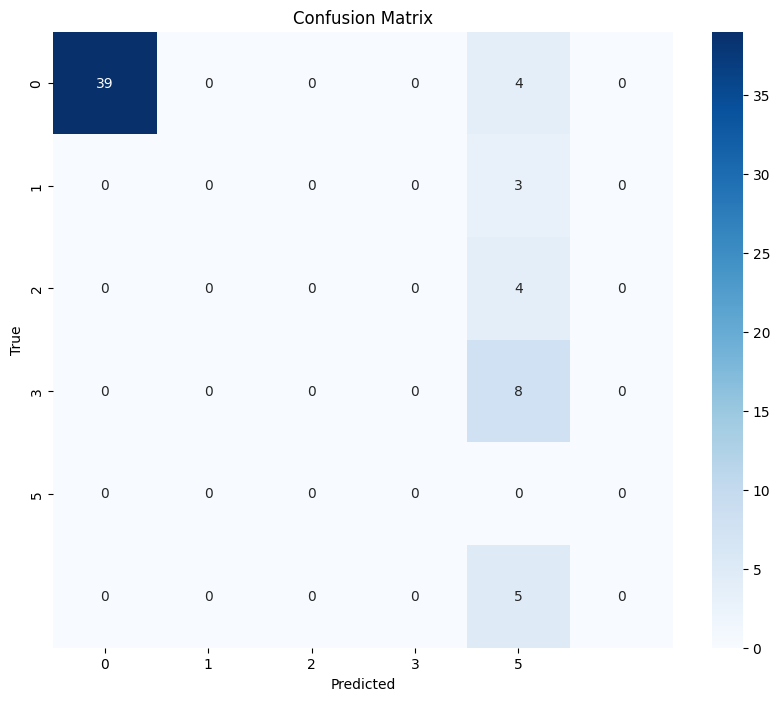

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create a heatmap with labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
